# Inferencia del DETR

El siguiente Notebook tiene como único propósito facilitar la prueba de los modelos entrenados para la detección de objetos con el DETR.

In [1]:
!pip install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [3]:
torch_version = torch.__version__
assert float(torch_version[:3]) >= 1.5
torch_version

'1.7.0+cu101'

In [4]:
%mkdir models

%cp /content/drive/MyDrive/Trabajo_CI/checkpoint0099.pth models/

%cp /content/drive/MyDrive/Trabajo_CI/checkpoint0199.pth models/

%cp /content/drive/MyDrive/Trabajo_CI_no_resize/checkpoint0099_no_resize.pth models/

%cp /content/drive/MyDrive/Trabajo_CI_no_resize/checkpoint0199_no_resize.pth models/

%cp -r /content/drive/MyDrive/Trabajo_CI/test_images/ .

In [5]:
%matplotlib inline
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

finetuned_classes = [
      'N/A', 'danger', 'mandatory', 'other', 'prohibitory'
  ]

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def filter_bboxes_from_outputs(outputs, threshold):
  
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [7]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
def run_worflow(my_image, my_model):
  img = transform(my_image).unsqueeze(0)

  outputs = my_model(img)

  for threshold in [1, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)

In [9]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       num_classes=5)

checkpoint = torch.load('/content/models/checkpoint0199_no_resize.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


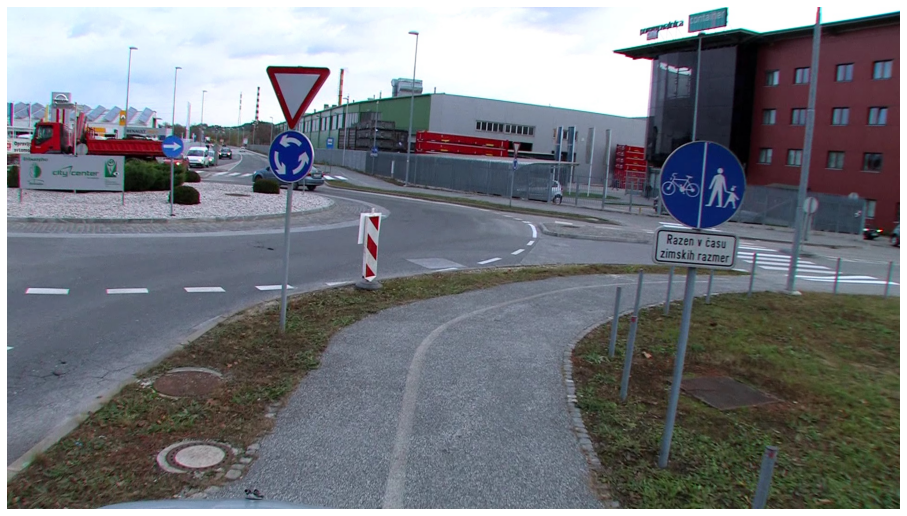

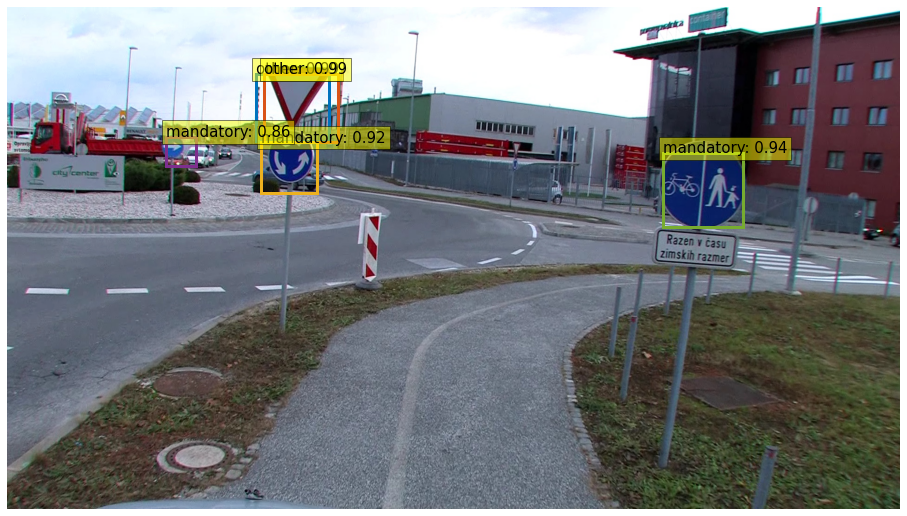

In [10]:
from PIL import Image
img_name = '/content/test_images/5.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)